# BCycle Austin models

This notebook concludes the BCycle Austin series of blog posts, and looks at how machine learning could be used to help the BCycle team. I'll be using weather data in addition to the station and bike information, and building models which I hope might be useful. Let's get started !

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading and cleaning weather data

I used [Weather Underground](https://www.wunderground.com/history/airport/KATT/2016/4/1/CustomHistory.html?dayend=3 1&monthend=5&yearend=2016&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1) to download a CSV with daily weather information from Austin's Camp Mabry station (KATT). This includes the following data fields:

* Date
* Min, mean, and max:
  * Temperature (degrees Fahreinheit)
  * Dew Point (degrees Fahreinheit)
  * Humidity (%)
  * Sea Level Pressure (inches)
  * Visibility (miles)
  * Wind speed (mph)
* Max gust (mph)
* Precipitation (inches)
* Events (combinations of Fog, Rain, Thunderstorm)

The `load_weather` function includes a lot of cleaning and pre-processing to get the raw CSV into a good state for the rest of the analysis.

In [2]:
weather_df = load_weather()
weather_df.head(6)

,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct,thunderstorm,rain,fog
date,,,,,,,,,,,,,,
2016-04-01,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,True,True,False
2016-04-02,74,45,76,23,30.32,30.18,13,5,20,0.00,0.0,False,False,False
2016-04-03,79,44,89,27,30.26,30.08,12,3,17,0.00,0.0,False,False,False
2016-04-04,83,53,66,30,30.21,30.10,12,4,18,0.00,0.0,False,False,False
2016-04-05,82,53,66,33,30.22,30.03,15,5,25,0.00,0.0,False,False,False
2016-04-06,82,55,90,21,30.12,29.93,15,6,23,0.00,37.5,False,False,False


In [9]:
weather_df.describe()

,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,81.901639,62.360656,90.721311,53.475410,30.045246,29.867213,13.737705,5.295082,22.770492,0.235410,55.532787
std,5.682443,7.122810,8.374826,17.527699,0.121197,0.134872,3.224395,1.676745,5.643266,0.424349,34.348442
min,66.000000,44.000000,66.000000,15.000000,29.760000,29.540000,8.000000,2.000000,13.000000,0.000000,0.000000
25%,78.000000,58.000000,87.000000,40.000000,29.980000,29.780000,12.000000,4.000000,19.000000,0.000000,37.500000
50%,83.000000,63.000000,93.000000,56.000000,30.070000,29.900000,14.000000,5.000000,22.000000,0.010000,62.500000
75%,87.000000,67.000000,97.000000,67.000000,30.120000,29.960000,16.000000,7.000000,26.000000,0.310000,87.500000
max,91.000000,77.000000,100.000000,84.000000,30.320000,30.180000,21.000000,9.000000,37.000000,2.250000,100.000000


The summary above shows descriptive statistics for each of the numeric columns in the table. There is a good range of weather conditions in there, including:

* Min and max temperatures ranging from 44°F to 91°F.
* Wind speeds ranging from 2MPH to 21MPH, with individual gusts up to 37MPH !
* Maximum precipitation of 2.25 inches.
* Weather events including fog, thunderstorms, and rain (these aren't included in the summary statistics above).

This should give a good distribution of data to work from. But we have a wide mix of units in each column (MPH, °F, percentages, and weather conditions), so we may have to use some feature normalization to give good results later on.

# Visualizing weather in April/May 2016

Now we have the weather information in a convenient dataframe, we can make some plots to visualize the conditions during April and May. 

## Temperature plots

Let's see how the minimum and maximum temperatures varied.

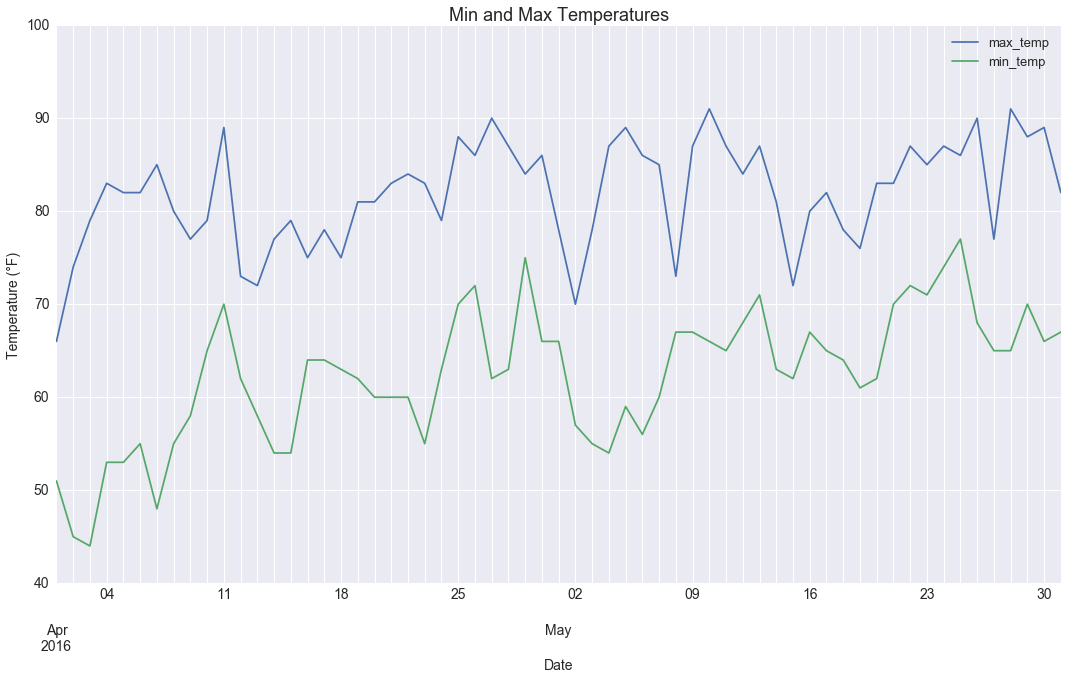

In [36]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df.plot(y=['max_temp', 'min_temp'], ax=ax)
ax.legend(fontsize=13)
xtick = pd.date_range( start=weather_df.index.min( ), end=weather_df.index.max( ), freq='D' )
ax.set_xticks( xtick )
# ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Temperature (°F)', fontdict={'size' : 14})
ax.set_title('Min and Max Temperatures', fontdict={'size' : 18}) 
# fig.autofmt_xdate(rotation=90)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The plot above shows the trends in minimum and maximum temperature during April and May 2016. The overall trend is an increase in both min and max temperatures, with a lot of variation in the changes in temperature. For example, around the 2nd May, the maximum temperature was less than the minimum temperature a few days earlier!

## Temperature distributions

Now we have an idea of how the temperature changed over time, we can check the distribution of min and max temperatures. Some of the models we'll be using expect features to be normally distributed, so we may need to transform the values if they aren't.

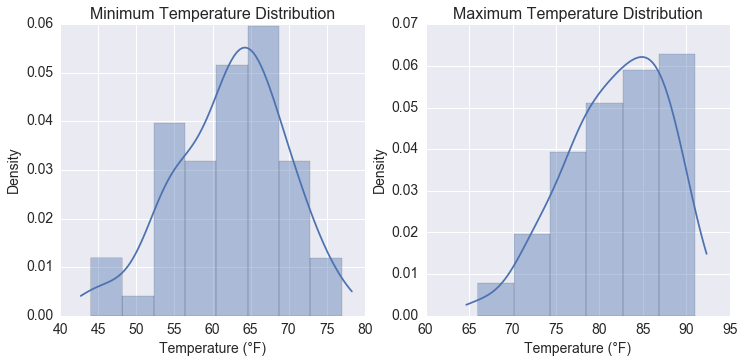

In [75]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

# ax[0] = weather_df['min_temp'].plot.hist(ax=ax[0]) # sns.distplot(weather_df['min_temp'], ax=ax[0])
# ax[1] = weather_df['max_temp'].plot.hist(ax=ax[1]) # sns.distplot(weather_df['max_temp'], ax=ax[1])

ax[0] = sns.distplot(weather_df['min_temp'], ax=ax[0])
ax[1] = sns.distplot(weather_df['max_temp'], ax=ax[1])

for axis in ax:
    axis.set_xlabel('Temperature (°F)', fontdict={'size' : 14})
    axis.set_ylabel('Density', fontdict={'size' : 14})

ax[0].set_title('Minimum Temperature Distribution', fontdict={'size' : 16}) 
ax[1].set_title('Maximum Temperature Distribution', fontdict={'size' : 16}) 

## Temperature pair plots

To see how the temperatures are correlated, let's use a pairplot.

ERROR! Session/line number was not unique in database. History logging moved to new session 792


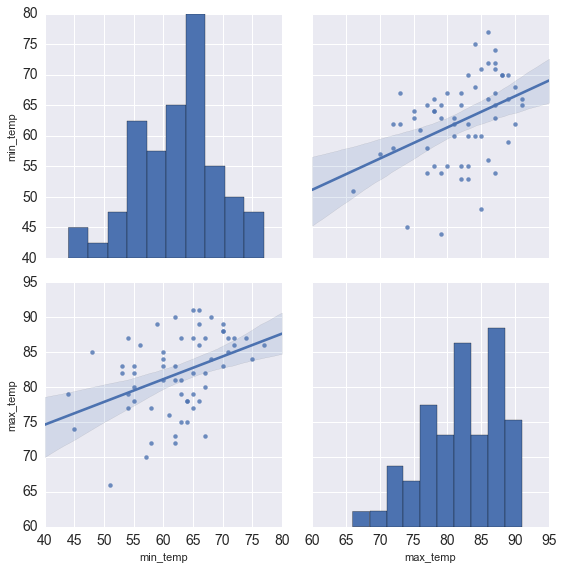

In [81]:
g = sns.pairplot(data=weather_df[['min_temp', 'max_temp']], kind='reg',size=4)

The pair plots show there's a reasonable correlation between the maximum and minimum temperatures.

## Pressure

Let's check the pressure difference in April and May. We don't perceive pressure as directly as temperature, precipitation, or thunderstorms. But there may be some interesting trends.

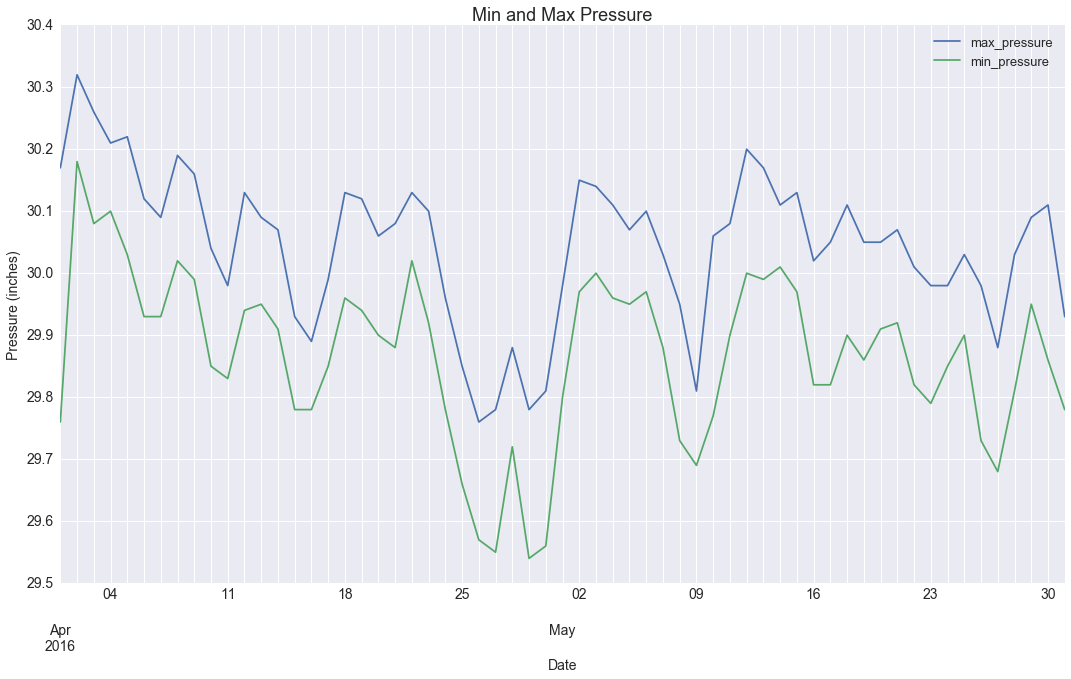

In [42]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df.plot(y=['max_pressure', 'min_pressure'], ax=ax)
ax.legend(fontsize=13)
xtick = pd.date_range( start=weather_df.index.min( ), end=weather_df.index.max( ), freq='D' )
ax.set_xticks( xtick )
# ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Pressure (inches)', fontdict={'size' : 14})
ax.set_title('Min and Max Pressure', fontdict={'size' : 18}) 
# fig.autofmt_xdate(rotation=90)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The plot shows both the max and min pressure as being highly correlated. There may also be correlations between the pressure and other more directly observable factors such as temperature and wind. 

## Precipitation

Let's take a look at the precipitation, to see how much it rained during the data collection phase. 

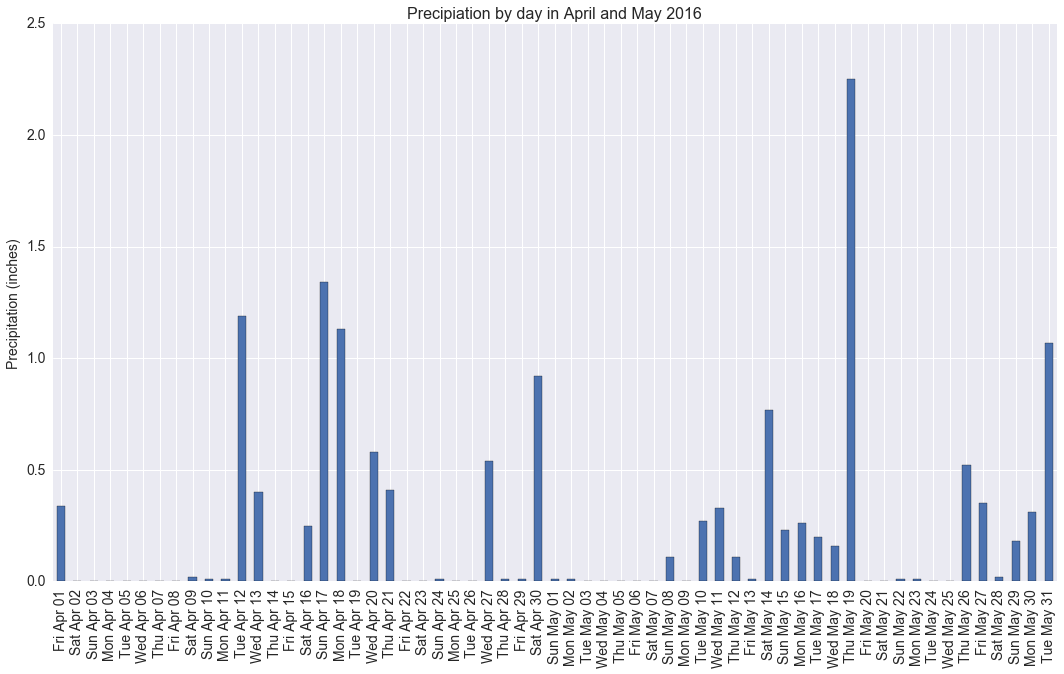

In [38]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df['precipitation'].plot.bar(ax=ax, legend=None)
ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('', fontdict={'size' : 14})
ax.set_ylabel('Precipitation (inches)', fontdict={'size' : 14})
ax.set_title('Precipiation by day in April and May 2016', fontdict={'size' : 16})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The graph shows there was some serious rain in April and May. As well as some dry spells through early April and May, there were also individual days where over an inch of rain fell. I'd definitely not be tempted to take a bike ride in those conditions !

## Precipitation histogram

To see how the distribution of rainfall looks, let's plot out the histogram and Kernel Density Estimate below. Based on the daily plot above, you can see there will likely be a very right skewed distribution with a long tail. For this reason, I'll use the pandas histogram directly, instead of fitting a Kernel Density Estimate.

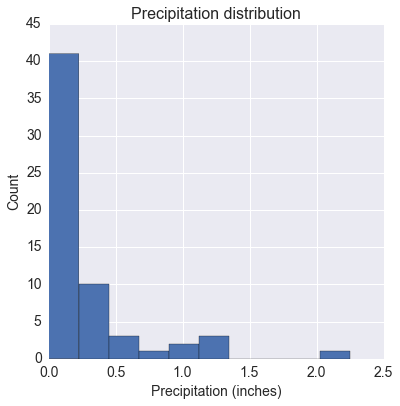

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax = weather_df['precipitation'].plot.hist(ax=ax)
ax.set_xlabel('Precipitation (inches)', fontdict={'size' : 14})
ax.set_ylabel('Count', fontdict={'size' : 14})
ax.set_title('Precipitation distribution', fontdict={'size' : 16}) 


This plot shows the majority of days had no rainfall at all. There were about 10 days with less than 0.5" of rain, and the count of days drops off steeply as the rainfall value increases. We may be able to transform this one-sided skewed distribution by setting a threshold, and converting to a boolean (above / below the threshold).

## Windspeed

The windspeed is likely to play a role in the amount of bike rentals too. I've plotted the minimum, maximum, and gust speeds in the line graph below.

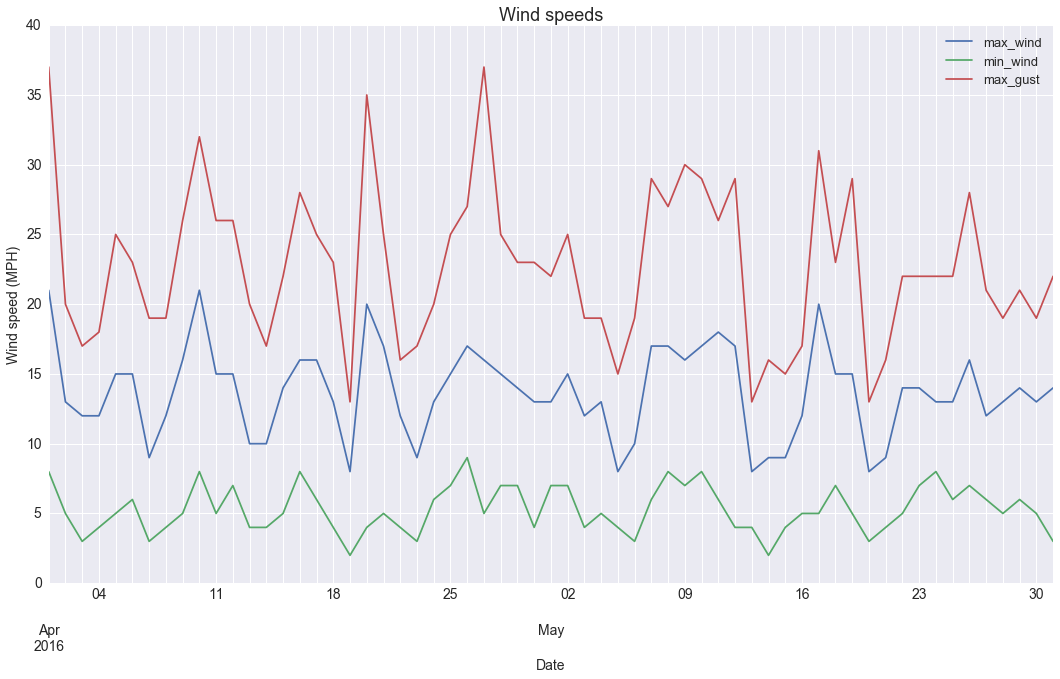

In [56]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df.plot(y=['max_wind', 'min_wind', 'max_gust'], ax=ax)
ax.legend(fontsize=13)
xtick = pd.date_range( start=weather_df.index.min( ), end=weather_df.index.max( ), freq='D' )
ax.set_xticks( xtick )
# ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Wind speed (MPH)', fontdict={'size' : 14})
ax.set_title('Wind speeds', fontdict={'size' : 18}) 
# fig.autofmt_xdate(rotation=90)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The graph shows a close correlation between the `min_wind`, `max_wind`, and `max_gust` speeds, as you'd expect. When building linear models, it's best to remove highly correlated values so we may just use the `max_gust` of the three based on how correlated they are.

## Wind speed distributions

As I suspect the wind speeds are very correlated, let's use a pairplot to see the correlations as well as individual distributions.

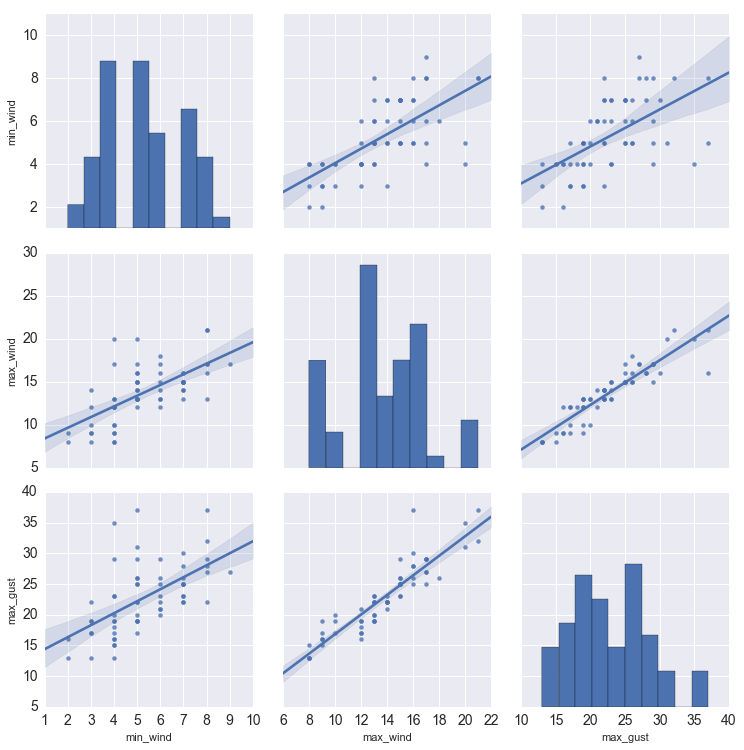

In [79]:
g = sns.pairplot(data=weather_df[['min_wind', 'max_wind', 'max_gust']], kind='reg',size=3.5)

This pairplot shows a high positive correlation between the `max_wind` and `max_gust`, as you'd expect. There is also a strong correlation between the minimum and maximum wind speeds. When building models, we probably need to take the `max_wind` or `max_gust` to avoid multiple correlated columns.

## Weather events

As well as the numeric weather values, there are 3 dummy variables for the events on each day. These are `thunderstorm`, `rain`, and `fog`. Let's plot these below.

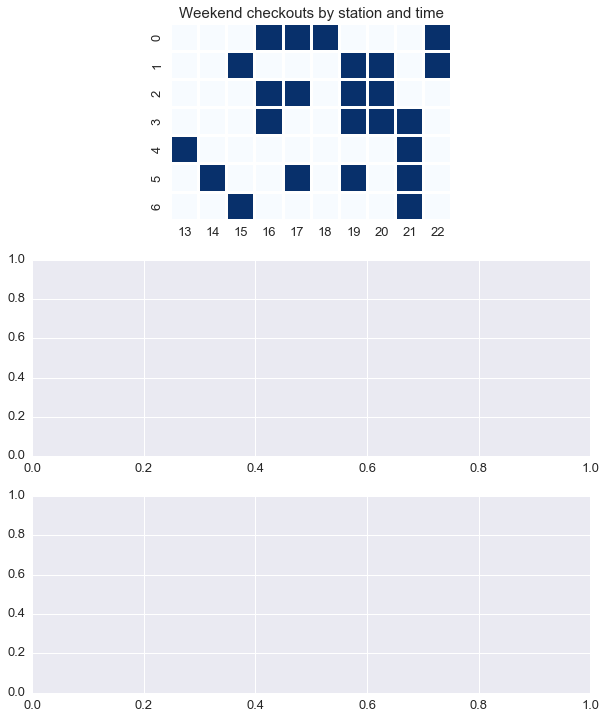

In [137]:
# weather_df[['thunderstorm', 'rain', 'fog']].plot.bar(figsize=(20,20))
heatmap_df = weather_df.copy()
heatmap_df = heatmap_df[['thunderstorm', 'rain', 'fog']]
heatmap_df = heatmap_df.reset_index()
heatmap_df['day'] = heatmap_df['date'].dt.dayofweek
heatmap_df['week'] = heatmap_df['date'].dt.week
heatmap_df = heatmap_df.pivot_table(values='thunderstorm', index='day', columns='week')
heatmap_df = heatmap_df.fillna(False)
# ['day'] = heatmap_df.index.dt.dayofweek

fig, axes = plt.subplots(3,1, figsize=(10,12))
sns.heatmap(data=heatmap_df, square=True, cmap='Blues', linewidth=2, cbar=False, linecolor='white', ax=axes[0])
axes[0].set_title('Weekend checkouts by station and time', fontdict={'size' : 15})


for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)



# heatmap_df